<a href="https://colab.research.google.com/github/surajgajul/Cocktails_model/blob/main/Beverages_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing Libraries

In [ ]:
import os
import numpy as np
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt

# Set the root directory where your category directories are located
root_dir = '/content/drive/MyDrive/Bev_Dataset/'

# Set the desired size for the resized images
target_size = (256, 256)

# Set the desired brightness enhancement factor (1.0 is no change, >1.0 is brighter, <1.0 is darker)
brightness_factor = 1.5

# Set up the image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,  # Adding vertical flip
    fill_mode='nearest'
)

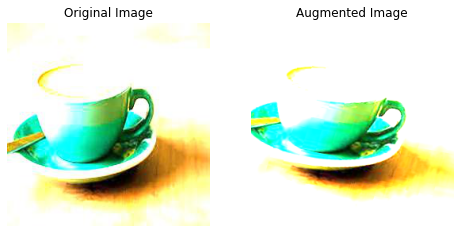

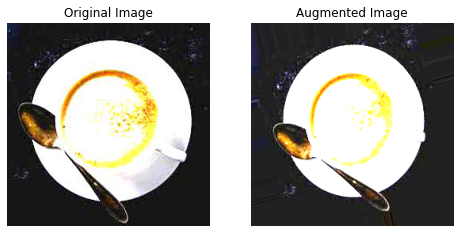

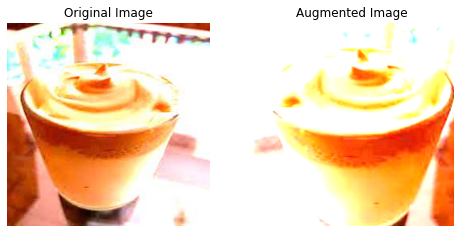

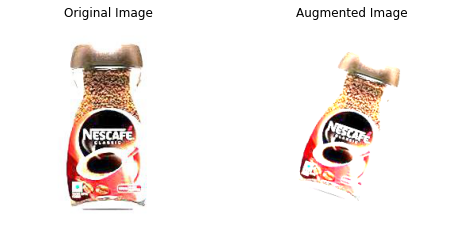

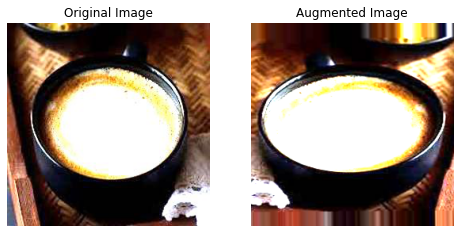

In [ ]:
# Set a counter to keep track of the number of images processed
counter = 0

# Loop through each category directory
for category in os.listdir(root_dir):
    category_dir = os.path.join(root_dir, category)
    # Loop through each file in the category directory
    for filename in os.listdir(category_dir):
        file_path = os.path.join(category_dir, filename)
        # Check if the file is an image
        if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png') or file_path.endswith('.JPG'):
            # Load the image
            image = load_img(file_path, target_size=target_size)
            # Convert the image to a Numpy array
            image_array = img_to_array(image)
            # Reshape the array to a 4D tensor with a single sample (for use with the ImageDataGenerator)
            image_array = image_array.reshape((1,) + image_array.shape)
            # Perform data augmentation on the image
            for batch in datagen.flow(image_array, batch_size=1):
                # Convert the batch (which will contain a single image) to a Numpy array
                batch = batch.reshape(batch.shape[1:])
                # Convert the Numpy array back to an image
                image = Image.fromarray(batch.astype('uint8'))
                # Enhance the brightness
                enhancer = ImageEnhance.Brightness(image)
                image = enhancer.enhance(brightness_factor)
                # Save the augmented image to a new file
                save_path = os.path.join(category_dir, f'augmented_{filename}')
                image.save(save_path)
                
                # Increment the counter
                counter += 1
                # Display changes for only the first few images
                if counter <= 5:
                    # Create a figure with two subplots, one for the original image and one for the augmented image
                    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                    # Load the original image and display it in the first subplot
                    orig_image = Image.open(file_path)
                    axs[0].imshow(orig_image)
                    axs[0].set_title('Original Image')
                    axs[0].axis('off')
                    # Display the augmented image in the second subplot
                    axs[1].imshow(image)
                    axs[1].set_title('Augmented Image')
                    axs[1].axis('off')
                    plt.show()
                
                # Stop the loop if we've generated enough augmented images
                if len(os.listdir(category_dir)) >= 100:
                    break

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
batch_size = 64
num_epochs = 12

In [ ]:
# Load the VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Freeze the layers of the pre-trained model so that we only train the last few layers
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# Add new layers on top of the pre-trained model for our specific task
x = vgg.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model by combining the pre-trained model and our new layers
model = Model(inputs=vgg.input, outputs=predictions)

# Compile the model with an optimizer, loss function, and evaluation metrics
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split
labels = []
filenames = []
for category in os.listdir(root_dir):
    category_dir = os.path.join(root_dir, category)
    for filename in os.listdir(category_dir):
        file_path = os.path.join(category_dir, filename)
        if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png') or file_path.endswith('.JPG'):
            labels.append(category)
            filenames.append(file_path)

# Split the data into training and validation sets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames, labels, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_filenames, 'label': train_labels}),
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_filenames, 'label': val_labels}),
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2000 validated image filenames belonging to 7 classes.
Found 500 validated image filenames belonging to 7 classes.


In [ ]:
model.fit(train_generator, epochs=num_epochs, validation_data=val_generator)

Epoch 1/12
32/32 [==============================] - 66s 2s/step - loss: 11.0225 - accuracy: 0.3420 - val_loss: 2.7719 - val_accuracy: 0.5500
Epoch 2/12
32/32 [==============================] - 49s 2s/step - loss: 2.8389 - accuracy: 0.5190 - val_loss: 1.8060 - val_accuracy: 0.5560
Epoch 3/12
32/32 [==============================] - 48s 2s/step - loss: 1.7117 - accuracy: 0.5645 - val_loss: 1.4299 - val_accuracy: 0.5900
Epoch 4/12
32/32 [==============================] - 47s 1s/step - loss: 1.4317 - accuracy: 0.5805 - val_loss: 1.2192 - val_accuracy: 0.6080
Epoch 5/12
32/32 [==============================] - 46s 1s/step - loss: 1.2667 - accuracy: 0.5930 - val_loss: 1.1225 - val_accuracy: 0.6280
Epoch 6/12
32/32 [==============================] - 48s 2s/step - loss: 1.1224 - accuracy: 0.6380 - val_loss: 1.0829 - val_accuracy: 0.6400
Epoch 7/12
32/32 [==============================] - 46s 1s/step - loss: 1.0119 - accuracy: 0.6625 - val_loss: 1.0161 - val_accuracy: 0.6540
Epoch 8/12
32/32 [=

In [ ]:
from keras.preprocessing import image
import tensorflow

x = tensorflow.keras.utils.load_img("/content/drive/MyDrive/Alcohol_Dataset/wine/wine-500.jpg", target_size=(256,256))
img = np.array(x)
x = np.expand_dims(x, axis=0)
predi=model.predict(x)
print(predi)
classes_x=np.argmax(predi)    
print(classes_x)

classes=["beer","cocktails","coffee","soft drinks","sports drinks","water", "wine"]  
prediction_label=classes[classes_x]
if(prediction_label=="beer"):
  print("It is a Beer")
elif(prediction_label=="cocktails"):
  print("It is a cocktails")
elif(prediction_label=="coffee"):
  print("It is a coffee")
elif(prediction_label=="soft drinks"):
  print("It is a soft drinks")
elif(prediction_label=="sports drinks"):
  print("It is a sports drinks")
elif(prediction_label=="water"):
  print("It is a water")
else:
  print("It is a wine")

1/1 [==============================] - 0s 24ms/step
[[1.3188557e-01 1.1250730e-07 6.8531145e-04 3.9928788e-03 5.3119785e-03
  7.9578835e-01 6.2335718e-02]]
5
It is a water
